## Statistical Analysis

#### Cleaning for statistical part

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
# Load dataset
df = pd.read_csv("train.csv")

In [7]:
# Step 1: Handle Missing Values
df = df.dropna()  # Drop rows with missing values (or use df.fillna(method='ffill') for forward fill)

In [9]:
# Step 2: Encode Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [11]:
# Step 3: Remove Highly Correlated Features
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
df = df.drop(columns=high_corr_features)
df = df.drop(columns=['Var1'])  # Drop column 'Var1' 

In [13]:
# Step 4: Scale Numerical Features
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [15]:
# Step 5: Remove Outliers using IQR Method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

### Corellation

In [19]:
# Step 1: Check missing values
print("Missing values before processing:\n", df.isnull().sum())

Missing values before processing:
 ID                                     0
Gender                                 0
DOB                                    0
Lead_Creation_Date                     0
City_Code                              0
City_Category                          0
Employer_Code                          0
Employer_Category1                     0
Employer_Category2                     0
Monthly_Income                         0
Customer_Existing_Primary_Bank_Code    0
Primary_Bank_Type                      0
Contacted                              0
Source                                 0
Source_Category                        0
Existing_EMI                           0
Loan_Amount                            0
Loan_Period                            0
Interest_Rate                          0
Approved                               0
dtype: int64


In [21]:
# Step 2: Fix Gender column
if 'Gender' in df.columns:
    if df['Gender'].isnull().all():
        df['Gender'] = np.random.choice([0, 1], size=df.shape[0])  # If all missing, fill randomly
    else:
        df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])  # Fill missing with mode
    df['Gender'] = df['Gender'].astype('category').cat.codes  # Convert to 0 & 1


In [23]:
# Step 3: Fix Employer_Category2, Contacted, Approved
for col in ['Employer_Category2', 'Contacted', 'Approved']:
    if col in df.columns:
        if df[col].isnull().all():
            df[col] = 0  # If all missing, set to 0
        else:
            df[col] = df[col].fillna(df[col].mode()[0])  # Fill with mode
        df[col] = df[col].astype('category').cat.codes  # Convert categorical to numerical

In [25]:
# Step 4: Ensure columns are not constant (add small variation if needed)
for col in ['Gender', 'Employer_Category2', 'Contacted', 'Approved']:
    if col in df.columns and df[col].nunique() == 1:
        df[col] += np.random.randint(0, 2, size=df.shape[0])  # Add variation

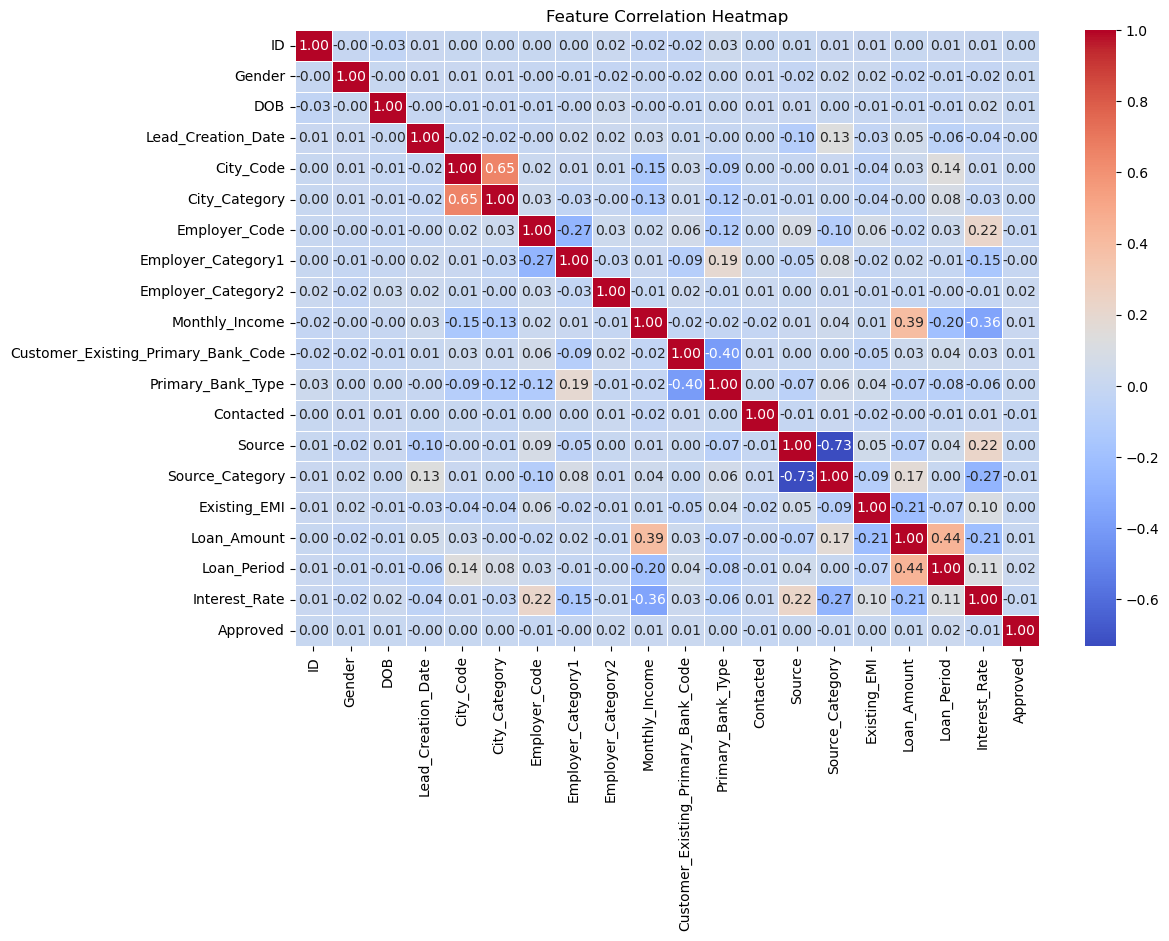

In [27]:
# Step 5: Compute and display the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

###  Chi-Square Test (Categorical Variables)

In [31]:
# Step 1: Select categorical variables for Chi-Square Test (e.g., Gender vs. Approved)
crosstab = pd.crosstab(df['Gender'], df['Approved'])

In [33]:
# Step 2: Perform Chi-Square Test
chi2_stat, p_val, dof, expected = stats.chi2_contingency(crosstab)

In [35]:
# Step 3: Display results and Interpretation
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_val)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

alpha = 0.05
if p_val < alpha:
    print("Reject null hypothesis: There is significant association among Gender and Loan Approval.")
else:
    print("Fail to reject null hypothesis: No significant association among Gender and Loan Approval.")


Chi-Square Statistic: 0.1741206694010783
P-Value: 0.6764753060695142
Degrees of Freedom: 1
Expected Frequencies:
[[1520.4631969 1489.5368031]
 [1478.5368031 1448.4631969]]
Fail to reject null hypothesis: No significant association among Gender and Loan Approval.


### Independent T-test

In [39]:
# Step 1: Perform Independent T-test on Monthly Income based on Loan Approval
group1 = df[df['Approved'] == 0]['Monthly_Income'].dropna()
group2 = df[df['Approved'] == 1]['Monthly_Income'].dropna()

t_stat, t_p_val = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's T-test

In [41]:
# Step 2: Display T-test results and interpretation
print("T-Statistic:", t_stat)
print("P-Value:", t_p_val)

if t_p_val < alpha:
    print("Reject the null hypothesis: There is significant difference in Monthly Income among approved and non-approved applicants.")
else:
    print("Fail to reject null hypothesis: No significant difference in Monthly Income among approved and non-approved applicants.")

T-Statistic: -0.5367428681573746
P-Value: 0.5914653661818161
Fail to reject null hypothesis: No significant difference in Monthly Income among approved and non-approved applicants.


### Random Forest Regressor model

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [79]:
# Step 1: Define features and target
features = ["Monthly_Income", "Loan_Period", "Existing_EMI"]
target = "Loan_Amount"

X = df[features]
y = df[target]

In [81]:
# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Step 3: Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [85]:
# Step 4: Make predictions
y_pred = rf.predict(X_test)

In [87]:
# Step 5: Evaluate performance
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 0.28957271411158264
MSE: 0.18606556359988774
RMSE: 0.4313531773383473
R2 Score: 0.5792658170722353


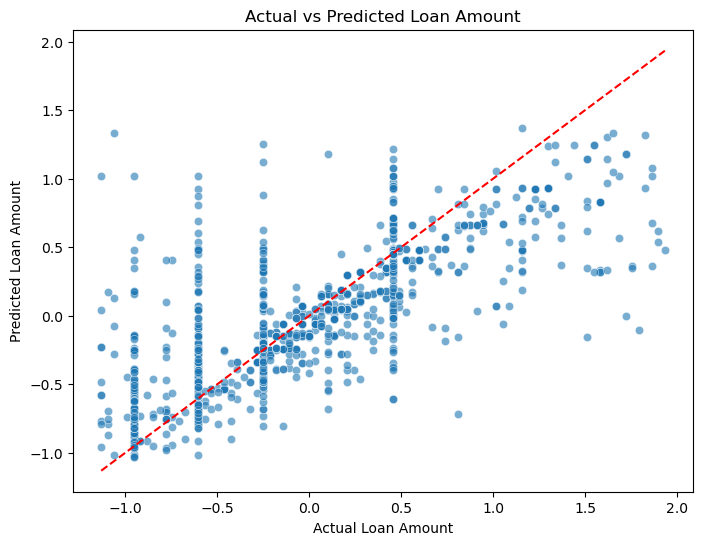

In [89]:
# Step 6: Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel("Actual Loan Amount")
plt.ylabel("Predicted Loan Amount")
plt.title("Actual vs Predicted Loan Amount")
plt.show()

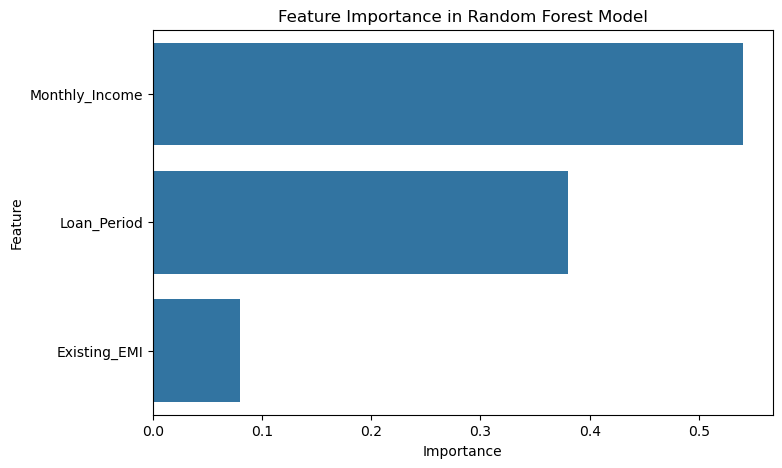

In [91]:
# Step 7: Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(x=rf.feature_importances_, y=features)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()
